In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'silu',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

silu_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 828)
(631390, 1)
validation
(74368, 828)
(74368, 1)
test
(85358, 828)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:55 - loss: 0.1122 - STD: 0.0057 - MAE: 0.3200

 3/64 [>.............................] - ETA: 1s - loss: 0.0465 - STD: 0.0120 - MAE: 0.1621  

 4/64 [>.............................] - ETA: 2s - loss: 0.0394 - STD: 0.0102 - MAE: 0.1513

 5/64 [=>............................] - ETA: 3s - loss: 0.0335 - STD: 0.0107 - MAE: 0.1361

 6/64 [=>............................] - ETA: 3s - loss: 0.0300 - STD: 0.0113 - MAE: 0.1266

 7/64 [==>...........................] - ETA: 3s - loss: 0.0272 - STD: 0.0117 - MAE: 0.1191

 8/64 [==>...........................] - ETA: 3s - loss: 0.0251 - STD: 0.0117 - MAE: 0.1145

 9/64 [===>..........................] - ETA: 3s - loss: 0.0235 - STD: 0.0119 - MAE: 0.1119

10/64 [===>..........................] - ETA: 3s - loss: 0.0221 - STD: 0.0124 - MAE: 0.1081

11/64 [====>.........................] - ETA: 3s - loss: 0.0210 - STD: 0.0131 - MAE: 0.1049

12/64 [====>.........................] - ETA: 3s - loss: 0.0200 - STD: 0.0138 - MAE: 0.1021

13/64 [=====>........................] - ETA: 3s - loss: 0.0192 - STD: 0.0146 - MAE: 0.0999

14/64 [=====>........................] - ETA: 3s - loss: 0.0185 - STD: 0.0153 - MAE: 0.0985

15/64 [======>.......................] - ETA: 3s - loss: 0.0179 - STD: 0.0161 - MAE: 0.0973

16/64 [======>.......................] - ETA: 3s - loss: 0.0173 - STD: 0.0170 - MAE: 0.0958

17/64 [======>.......................] - ETA: 3s - loss: 0.0168 - STD: 0.0178 - MAE: 0.0942

18/64 [=======>......................] - ETA: 3s - loss: 0.0163 - STD: 0.0187 - MAE: 0.0928

19/64 [=======>......................] - ETA: 3s - loss: 0.0159 - STD: 0.0196 - MAE: 0.0916

20/64 [========>.....................] - ETA: 3s - loss: 0.0155 - STD: 0.0205 - MAE: 0.0907

21/64 [========>.....................] - ETA: 3s - loss: 0.0152 - STD: 0.0214 - MAE: 0.0901

22/64 [=========>....................] - ETA: 3s - loss: 0.0149 - STD: 0.0222 - MAE: 0.0893

23/64 [=========>....................] - ETA: 3s - loss: 0.0146 - STD: 0.0230 - MAE: 0.0884

24/64 [==========>...................] - ETA: 3s - loss: 0.0143 - STD: 0.0236 - MAE: 0.0875

25/64 [==========>...................] - ETA: 3s - loss: 0.0141 - STD: 0.0243 - MAE: 0.0867

26/64 [===========>..................] - ETA: 3s - loss: 0.0139 - STD: 0.0249 - MAE: 0.0862

27/64 [===========>..................] - ETA: 2s - loss: 0.0136 - STD: 0.0254 - MAE: 0.0857

28/64 [============>.................] - ETA: 2s - loss: 0.0134 - STD: 0.0259 - MAE: 0.0852

29/64 [============>.................] - ETA: 2s - loss: 0.0132 - STD: 0.0265 - MAE: 0.0845

30/64 [=============>................] - ETA: 2s - loss: 0.0131 - STD: 0.0270 - MAE: 0.0840

31/64 [=============>................] - ETA: 2s - loss: 0.0129 - STD: 0.0275 - MAE: 0.0835

32/64 [==============>...............] - ETA: 2s - loss: 0.0128 - STD: 0.0280 - MAE: 0.0831

33/64 [==============>...............] - ETA: 2s - loss: 0.0126 - STD: 0.0285 - MAE: 0.0827

34/64 [==============>...............] - ETA: 2s - loss: 0.0125 - STD: 0.0290 - MAE: 0.0823

35/64 [===============>..............] - ETA: 2s - loss: 0.0123 - STD: 0.0294 - MAE: 0.0818

36/64 [===============>..............] - ETA: 2s - loss: 0.0122 - STD: 0.0299 - MAE: 0.0813

37/64 [================>.............] - ETA: 2s - loss: 0.0121 - STD: 0.0302 - MAE: 0.0810

38/64 [================>.............] - ETA: 2s - loss: 0.0119 - STD: 0.0306 - MAE: 0.0807

39/64 [=================>............] - ETA: 2s - loss: 0.0118 - STD: 0.0310 - MAE: 0.0803

40/64 [=================>............] - ETA: 1s - loss: 0.0117 - STD: 0.0313 - MAE: 0.0799

41/64 [==================>...........] - ETA: 1s - loss: 0.0116 - STD: 0.0317 - MAE: 0.0796

42/64 [==================>...........] - ETA: 1s - loss: 0.0115 - STD: 0.0321 - MAE: 0.0793

43/64 [===================>..........] - ETA: 1s - loss: 0.0114 - STD: 0.0324 - MAE: 0.0790

44/64 [===================>..........] - ETA: 1s - loss: 0.0113 - STD: 0.0327 - MAE: 0.0786

45/64 [====================>.........] - ETA: 1s - loss: 0.0112 - STD: 0.0331 - MAE: 0.0784

46/64 [====================>.........] - ETA: 1s - loss: 0.0111 - STD: 0.0334 - MAE: 0.0780

47/64 [=====================>........] - ETA: 1s - loss: 0.0111 - STD: 0.0337 - MAE: 0.0778

48/64 [=====================>........] - ETA: 1s - loss: 0.0110 - STD: 0.0340 - MAE: 0.0775

49/64 [=====================>........] - ETA: 1s - loss: 0.0109 - STD: 0.0343 - MAE: 0.0772

50/64 [======================>.......] - ETA: 1s - loss: 0.0108 - STD: 0.0347 - MAE: 0.0769

51/64 [======================>.......] - ETA: 1s - loss: 0.0107 - STD: 0.0350 - MAE: 0.0765

52/64 [=======================>......] - ETA: 0s - loss: 0.0107 - STD: 0.0355 - MAE: 0.0767

53/64 [=======================>......] - ETA: 0s - loss: 0.0111 - STD: 0.0352 - MAE: 0.0780

54/64 [========================>.....] - ETA: 0s - loss: 0.0114 - STD: 0.0349 - MAE: 0.0792

55/64 [========================>.....] - ETA: 0s - loss: 0.0114 - STD: 0.0349 - MAE: 0.0791

56/64 [=========================>....] - ETA: 0s - loss: 0.0114 - STD: 0.0352 - MAE: 0.0794

59/64 [==========================>...] - ETA: 0s - loss: 0.0113 - STD: 0.0349 - MAE: 0.0792

61/64 [===========================>..] - ETA: 0s - loss: 0.0112 - STD: 0.0344 - MAE: 0.0789

62/64 [============================>.] - ETA: 0s - loss: 0.0112 - STD: 0.0343 - MAE: 0.0790

63/64 [============================>.] - ETA: 0s - loss: 0.0112 - STD: 0.0343 - MAE: 0.0789

64/64 [==============================] - ETA: 0s - loss: 0.0111 - STD: 0.0344 - MAE: 0.0787

64/64 [==============================] - 8s 99ms/step - loss: 0.0111 - STD: 0.0344 - MAE: 0.0787 - val_loss: 0.0083 - val_STD: 0.0303 - val_MAE: 0.0663


Epoch 2/10000


 1/64 [..............................] - ETA: 8s - loss: 0.0085 - STD: 0.0426 - MAE: 0.0663

 2/64 [..............................] - ETA: 5s - loss: 0.0086 - STD: 0.0435 - MAE: 0.0668

 3/64 [>.............................] - ETA: 4s - loss: 0.0082 - STD: 0.0448 - MAE: 0.0665

 4/64 [>.............................] - ETA: 5s - loss: 0.0082 - STD: 0.0458 - MAE: 0.0686

 5/64 [=>............................] - ETA: 5s - loss: 0.0083 - STD: 0.0464 - MAE: 0.0701

 6/64 [=>............................] - ETA: 4s - loss: 0.0082 - STD: 0.0467 - MAE: 0.0699

 7/64 [==>...........................] - ETA: 4s - loss: 0.0081 - STD: 0.0467 - MAE: 0.0691

 8/64 [==>...........................] - ETA: 4s - loss: 0.0081 - STD: 0.0465 - MAE: 0.0686

 9/64 [===>..........................] - ETA: 4s - loss: 0.0080 - STD: 0.0463 - MAE: 0.0682

10/64 [===>..........................] - ETA: 4s - loss: 0.0079 - STD: 0.0459 - MAE: 0.0680

11/64 [====>.........................] - ETA: 4s - loss: 0.0079 - STD: 0.0457 - MAE: 0.0683

12/64 [====>.........................] - ETA: 4s - loss: 0.0079 - STD: 0.0454 - MAE: 0.0685

13/64 [=====>........................] - ETA: 4s - loss: 0.0078 - STD: 0.0451 - MAE: 0.0683

14/64 [=====>........................] - ETA: 4s - loss: 0.0078 - STD: 0.0448 - MAE: 0.0680

15/64 [======>.......................] - ETA: 4s - loss: 0.0078 - STD: 0.0447 - MAE: 0.0677

16/64 [======>.......................] - ETA: 4s - loss: 0.0077 - STD: 0.0447 - MAE: 0.0675

17/64 [======>.......................] - ETA: 3s - loss: 0.0077 - STD: 0.0448 - MAE: 0.0674

18/64 [=======>......................] - ETA: 3s - loss: 0.0077 - STD: 0.0450 - MAE: 0.0675

19/64 [=======>......................] - ETA: 3s - loss: 0.0076 - STD: 0.0453 - MAE: 0.0673

20/64 [========>.....................] - ETA: 3s - loss: 0.0076 - STD: 0.0455 - MAE: 0.0671

21/64 [========>.....................] - ETA: 3s - loss: 0.0076 - STD: 0.0458 - MAE: 0.0669

22/64 [=========>....................] - ETA: 3s - loss: 0.0076 - STD: 0.0462 - MAE: 0.0668

23/64 [=========>....................] - ETA: 3s - loss: 0.0075 - STD: 0.0466 - MAE: 0.0668

24/64 [==========>...................] - ETA: 3s - loss: 0.0075 - STD: 0.0470 - MAE: 0.0666

26/64 [===========>..................] - ETA: 3s - loss: 0.0075 - STD: 0.0475 - MAE: 0.0660

27/64 [===========>..................] - ETA: 3s - loss: 0.0074 - STD: 0.0479 - MAE: 0.0659

28/64 [============>.................] - ETA: 2s - loss: 0.0074 - STD: 0.0481 - MAE: 0.0657

29/64 [============>.................] - ETA: 2s - loss: 0.0074 - STD: 0.0483 - MAE: 0.0655

30/64 [=============>................] - ETA: 2s - loss: 0.0073 - STD: 0.0485 - MAE: 0.0654

31/64 [=============>................] - ETA: 2s - loss: 0.0073 - STD: 0.0488 - MAE: 0.0653

32/64 [==============>...............] - ETA: 2s - loss: 0.0073 - STD: 0.0490 - MAE: 0.0651

33/64 [==============>...............] - ETA: 2s - loss: 0.0072 - STD: 0.0493 - MAE: 0.0649

34/64 [==============>...............] - ETA: 2s - loss: 0.0072 - STD: 0.0497 - MAE: 0.0648

35/64 [===============>..............] - ETA: 2s - loss: 0.0072 - STD: 0.0498 - MAE: 0.0646

36/64 [===============>..............] - ETA: 2s - loss: 0.0072 - STD: 0.0503 - MAE: 0.0646

37/64 [================>.............] - ETA: 2s - loss: 0.0072 - STD: 0.0504 - MAE: 0.0645

38/64 [================>.............] - ETA: 2s - loss: 0.0072 - STD: 0.0507 - MAE: 0.0644

39/64 [=================>............] - ETA: 2s - loss: 0.0071 - STD: 0.0510 - MAE: 0.0644

40/64 [=================>............] - ETA: 1s - loss: 0.0071 - STD: 0.0510 - MAE: 0.0642

41/64 [==================>...........] - ETA: 1s - loss: 0.0071 - STD: 0.0512 - MAE: 0.0641

42/64 [==================>...........] - ETA: 1s - loss: 0.0071 - STD: 0.0515 - MAE: 0.0641

43/64 [===================>..........] - ETA: 1s - loss: 0.0071 - STD: 0.0515 - MAE: 0.0640

44/64 [===================>..........] - ETA: 1s - loss: 0.0071 - STD: 0.0515 - MAE: 0.0639

45/64 [====================>.........] - ETA: 1s - loss: 0.0070 - STD: 0.0518 - MAE: 0.0639

46/64 [====================>.........] - ETA: 1s - loss: 0.0070 - STD: 0.0518 - MAE: 0.0638

47/64 [=====================>........] - ETA: 1s - loss: 0.0070 - STD: 0.0518 - MAE: 0.0637

48/64 [=====================>........] - ETA: 1s - loss: 0.0070 - STD: 0.0519 - MAE: 0.0636

49/64 [=====================>........] - ETA: 1s - loss: 0.0070 - STD: 0.0521 - MAE: 0.0636

50/64 [======================>.......] - ETA: 1s - loss: 0.0070 - STD: 0.0521 - MAE: 0.0635

51/64 [======================>.......] - ETA: 1s - loss: 0.0069 - STD: 0.0521 - MAE: 0.0633

52/64 [=======================>......] - ETA: 0s - loss: 0.0069 - STD: 0.0523 - MAE: 0.0633

53/64 [=======================>......] - ETA: 0s - loss: 0.0069 - STD: 0.0524 - MAE: 0.0632

54/64 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.0525 - MAE: 0.0631

55/64 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.0526 - MAE: 0.0630

56/64 [=========================>....] - ETA: 0s - loss: 0.0069 - STD: 0.0528 - MAE: 0.0629

57/64 [=========================>....] - ETA: 0s - loss: 0.0068 - STD: 0.0529 - MAE: 0.0628

58/64 [==========================>...] - ETA: 0s - loss: 0.0068 - STD: 0.0530 - MAE: 0.0627

59/64 [==========================>...] - ETA: 0s - loss: 0.0068 - STD: 0.0533 - MAE: 0.0626

60/64 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.0534 - MAE: 0.0625

61/64 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.0535 - MAE: 0.0624

62/64 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0537 - MAE: 0.0624

63/64 [============================>.] - ETA: 0s - loss: 0.0067 - STD: 0.0539 - MAE: 0.0623

64/64 [==============================] - ETA: 0s - loss: 0.0067 - STD: 0.0541 - MAE: 0.0622

64/64 [==============================] - 6s 86ms/step - loss: 0.0067 - STD: 0.0541 - MAE: 0.0622 - val_loss: 0.0053 - val_STD: 0.0526 - val_MAE: 0.0555


Epoch 3/10000


 1/64 [..............................] - ETA: 8s - loss: 0.0054 - STD: 0.0653 - MAE: 0.0553

 2/64 [..............................] - ETA: 5s - loss: 0.0054 - STD: 0.0654 - MAE: 0.0551

 3/64 [>.............................] - ETA: 5s - loss: 0.0055 - STD: 0.0659 - MAE: 0.0556

 4/64 [>.............................] - ETA: 5s - loss: 0.0055 - STD: 0.0658 - MAE: 0.0558

 5/64 [=>............................] - ETA: 5s - loss: 0.0055 - STD: 0.0655 - MAE: 0.0555

 6/64 [=>............................] - ETA: 5s - loss: 0.0056 - STD: 0.0663 - MAE: 0.0561

 7/64 [==>...........................] - ETA: 5s - loss: 0.0057 - STD: 0.0648 - MAE: 0.0562

 9/64 [===>..........................] - ETA: 4s - loss: 0.0059 - STD: 0.0643 - MAE: 0.0574

10/64 [===>..........................] - ETA: 4s - loss: 0.0058 - STD: 0.0641 - MAE: 0.0574

11/64 [====>.........................] - ETA: 4s - loss: 0.0059 - STD: 0.0644 - MAE: 0.0581

12/64 [====>.........................] - ETA: 4s - loss: 0.0061 - STD: 0.0626 - MAE: 0.0585

13/64 [=====>........................] - ETA: 3s - loss: 0.0061 - STD: 0.0614 - MAE: 0.0584

14/64 [=====>........................] - ETA: 3s - loss: 0.0063 - STD: 0.0616 - MAE: 0.0597

15/64 [======>.......................] - ETA: 3s - loss: 0.0063 - STD: 0.0606 - MAE: 0.0596

16/64 [======>.......................] - ETA: 3s - loss: 0.0064 - STD: 0.0594 - MAE: 0.0596

17/64 [======>.......................] - ETA: 3s - loss: 0.0063 - STD: 0.0584 - MAE: 0.0595

18/64 [=======>......................] - ETA: 3s - loss: 0.0063 - STD: 0.0580 - MAE: 0.0598

19/64 [=======>......................] - ETA: 3s - loss: 0.0064 - STD: 0.0577 - MAE: 0.0602

20/64 [========>.....................] - ETA: 3s - loss: 0.0064 - STD: 0.0572 - MAE: 0.0602

21/64 [========>.....................] - ETA: 3s - loss: 0.0064 - STD: 0.0567 - MAE: 0.0602

22/64 [=========>....................] - ETA: 3s - loss: 0.0064 - STD: 0.0564 - MAE: 0.0601

23/64 [=========>....................] - ETA: 3s - loss: 0.0064 - STD: 0.0564 - MAE: 0.0601

24/64 [==========>...................] - ETA: 3s - loss: 0.0064 - STD: 0.0566 - MAE: 0.0602

25/64 [==========>...................] - ETA: 3s - loss: 0.0064 - STD: 0.0567 - MAE: 0.0603

26/64 [===========>..................] - ETA: 3s - loss: 0.0064 - STD: 0.0566 - MAE: 0.0601

27/64 [===========>..................] - ETA: 2s - loss: 0.0063 - STD: 0.0565 - MAE: 0.0600

28/64 [============>.................] - ETA: 2s - loss: 0.0063 - STD: 0.0566 - MAE: 0.0599

29/64 [============>.................] - ETA: 2s - loss: 0.0063 - STD: 0.0568 - MAE: 0.0600

30/64 [=============>................] - ETA: 2s - loss: 0.0063 - STD: 0.0569 - MAE: 0.0600

31/64 [=============>................] - ETA: 2s - loss: 0.0063 - STD: 0.0569 - MAE: 0.0599

32/64 [==============>...............] - ETA: 2s - loss: 0.0063 - STD: 0.0568 - MAE: 0.0598

33/64 [==============>...............] - ETA: 2s - loss: 0.0063 - STD: 0.0570 - MAE: 0.0598

34/64 [==============>...............] - ETA: 2s - loss: 0.0063 - STD: 0.0572 - MAE: 0.0598

35/64 [===============>..............] - ETA: 2s - loss: 0.0063 - STD: 0.0572 - MAE: 0.0597

36/64 [===============>..............] - ETA: 2s - loss: 0.0062 - STD: 0.0573 - MAE: 0.0595

37/64 [================>.............] - ETA: 2s - loss: 0.0062 - STD: 0.0576 - MAE: 0.0596

38/64 [================>.............] - ETA: 2s - loss: 0.0062 - STD: 0.0578 - MAE: 0.0595

39/64 [=================>............] - ETA: 2s - loss: 0.0062 - STD: 0.0578 - MAE: 0.0593

40/64 [=================>............] - ETA: 1s - loss: 0.0062 - STD: 0.0581 - MAE: 0.0592

41/64 [==================>...........] - ETA: 1s - loss: 0.0062 - STD: 0.0584 - MAE: 0.0592

42/64 [==================>...........] - ETA: 1s - loss: 0.0062 - STD: 0.0584 - MAE: 0.0591

43/64 [===================>..........] - ETA: 1s - loss: 0.0062 - STD: 0.0585 - MAE: 0.0590

44/64 [===================>..........] - ETA: 1s - loss: 0.0062 - STD: 0.0589 - MAE: 0.0591

45/64 [====================>.........] - ETA: 1s - loss: 0.0061 - STD: 0.0589 - MAE: 0.0589

46/64 [====================>.........] - ETA: 1s - loss: 0.0061 - STD: 0.0590 - MAE: 0.0588

47/64 [=====================>........] - ETA: 1s - loss: 0.0061 - STD: 0.0592 - MAE: 0.0589

48/64 [=====================>........] - ETA: 1s - loss: 0.0061 - STD: 0.0592 - MAE: 0.0587

49/64 [=====================>........] - ETA: 1s - loss: 0.0061 - STD: 0.0592 - MAE: 0.0586

50/64 [======================>.......] - ETA: 1s - loss: 0.0061 - STD: 0.0594 - MAE: 0.0586

51/64 [======================>.......] - ETA: 1s - loss: 0.0061 - STD: 0.0594 - MAE: 0.0585

52/64 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0594 - MAE: 0.0585

53/64 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0596 - MAE: 0.0584

54/64 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0597 - MAE: 0.0584

55/64 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0597 - MAE: 0.0583

56/64 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0598 - MAE: 0.0582

57/64 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0600 - MAE: 0.0582

58/64 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0600 - MAE: 0.0581

59/64 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0601 - MAE: 0.0580

60/64 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0602 - MAE: 0.0580

61/64 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0603 - MAE: 0.0579

62/64 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0604 - MAE: 0.0578

63/64 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0605 - MAE: 0.0578

64/64 [==============================] - ETA: 0s - loss: 0.0059 - STD: 0.0606 - MAE: 0.0577

64/64 [==============================] - 6s 86ms/step - loss: 0.0059 - STD: 0.0606 - MAE: 0.0577 - val_loss: 0.0048 - val_STD: 0.0584 - val_MAE: 0.0529


Epoch 4/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0052 - STD: 0.0687 - MAE: 0.0539

 2/64 [..............................] - ETA: 5s - loss: 0.0052 - STD: 0.0681 - MAE: 0.0537

 3/64 [>.............................] - ETA: 5s - loss: 0.0052 - STD: 0.0678 - MAE: 0.0535

 4/64 [>.............................] - ETA: 4s - loss: 0.0052 - STD: 0.0683 - MAE: 0.0534

 5/64 [=>............................] - ETA: 4s - loss: 0.0051 - STD: 0.0684 - MAE: 0.0532

 6/64 [=>............................] - ETA: 4s - loss: 0.0051 - STD: 0.0688 - MAE: 0.0532

 7/64 [==>...........................] - ETA: 4s - loss: 0.0051 - STD: 0.0686 - MAE: 0.0532

 8/64 [==>...........................] - ETA: 4s - loss: 0.0051 - STD: 0.0693 - MAE: 0.0533

 9/64 [===>..........................] - ETA: 4s - loss: 0.0051 - STD: 0.0686 - MAE: 0.0531

10/64 [===>..........................] - ETA: 4s - loss: 0.0052 - STD: 0.0695 - MAE: 0.0538

11/64 [====>.........................] - ETA: 4s - loss: 0.0054 - STD: 0.0679 - MAE: 0.0543

12/64 [====>.........................] - ETA: 4s - loss: 0.0054 - STD: 0.0680 - MAE: 0.0545

13/64 [=====>........................] - ETA: 4s - loss: 0.0054 - STD: 0.0678 - MAE: 0.0548

14/64 [=====>........................] - ETA: 4s - loss: 0.0055 - STD: 0.0665 - MAE: 0.0549

15/64 [======>.......................] - ETA: 4s - loss: 0.0055 - STD: 0.0661 - MAE: 0.0549

16/64 [======>.......................] - ETA: 4s - loss: 0.0055 - STD: 0.0663 - MAE: 0.0554

17/64 [======>.......................] - ETA: 3s - loss: 0.0055 - STD: 0.0654 - MAE: 0.0554

18/64 [=======>......................] - ETA: 3s - loss: 0.0055 - STD: 0.0647 - MAE: 0.0553

19/64 [=======>......................] - ETA: 3s - loss: 0.0056 - STD: 0.0648 - MAE: 0.0557

20/64 [========>.....................] - ETA: 3s - loss: 0.0056 - STD: 0.0645 - MAE: 0.0557

21/64 [========>.....................] - ETA: 3s - loss: 0.0056 - STD: 0.0640 - MAE: 0.0557

22/64 [=========>....................] - ETA: 3s - loss: 0.0056 - STD: 0.0637 - MAE: 0.0557

23/64 [=========>....................] - ETA: 3s - loss: 0.0056 - STD: 0.0639 - MAE: 0.0560

24/64 [==========>...................] - ETA: 3s - loss: 0.0056 - STD: 0.0637 - MAE: 0.0559

25/64 [==========>...................] - ETA: 3s - loss: 0.0056 - STD: 0.0634 - MAE: 0.0558

26/64 [===========>..................] - ETA: 3s - loss: 0.0056 - STD: 0.0634 - MAE: 0.0558

27/64 [===========>..................] - ETA: 3s - loss: 0.0056 - STD: 0.0635 - MAE: 0.0559

28/64 [============>.................] - ETA: 3s - loss: 0.0056 - STD: 0.0634 - MAE: 0.0558

29/64 [============>.................] - ETA: 2s - loss: 0.0056 - STD: 0.0633 - MAE: 0.0557

30/64 [=============>................] - ETA: 2s - loss: 0.0056 - STD: 0.0636 - MAE: 0.0558

31/64 [=============>................] - ETA: 2s - loss: 0.0055 - STD: 0.0635 - MAE: 0.0556

32/64 [==============>...............] - ETA: 2s - loss: 0.0055 - STD: 0.0636 - MAE: 0.0556

33/64 [==============>...............] - ETA: 2s - loss: 0.0055 - STD: 0.0639 - MAE: 0.0556

34/64 [==============>...............] - ETA: 2s - loss: 0.0055 - STD: 0.0639 - MAE: 0.0555

35/64 [===============>..............] - ETA: 2s - loss: 0.0055 - STD: 0.0641 - MAE: 0.0554

36/64 [===============>..............] - ETA: 2s - loss: 0.0055 - STD: 0.0643 - MAE: 0.0554

37/64 [================>.............] - ETA: 2s - loss: 0.0055 - STD: 0.0644 - MAE: 0.0553

38/64 [================>.............] - ETA: 2s - loss: 0.0055 - STD: 0.0647 - MAE: 0.0552

40/64 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.0650 - MAE: 0.0551

41/64 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0653 - MAE: 0.0551

42/64 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0652 - MAE: 0.0550

43/64 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0654 - MAE: 0.0550

44/64 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0654 - MAE: 0.0549

45/64 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0654 - MAE: 0.0548

46/64 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0655 - MAE: 0.0548

47/64 [=====================>........] - ETA: 1s - loss: 0.0054 - STD: 0.0655 - MAE: 0.0548

48/64 [=====================>........] - ETA: 1s - loss: 0.0054 - STD: 0.0656 - MAE: 0.0547

49/64 [=====================>........] - ETA: 1s - loss: 0.0054 - STD: 0.0656 - MAE: 0.0547

50/64 [======================>.......] - ETA: 1s - loss: 0.0054 - STD: 0.0657 - MAE: 0.0546

51/64 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0658 - MAE: 0.0546

52/64 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0660 - MAE: 0.0545

53/64 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0659 - MAE: 0.0545

54/64 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0662 - MAE: 0.0546

55/64 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0659 - MAE: 0.0546

56/64 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0660 - MAE: 0.0547

57/64 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0659 - MAE: 0.0547

58/64 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0658 - MAE: 0.0546

59/64 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0658 - MAE: 0.0547

60/64 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0657 - MAE: 0.0546

61/64 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0657 - MAE: 0.0545

62/64 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0658 - MAE: 0.0546

63/64 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0657 - MAE: 0.0545

64/64 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0658 - MAE: 0.0545

64/64 [==============================] - 5s 74ms/step - loss: 0.0053 - STD: 0.0658 - MAE: 0.0545 - val_loss: 0.0047 - val_STD: 0.0628 - val_MAE: 0.0538


Epoch 5/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0051 - STD: 0.0732 - MAE: 0.0546

 2/64 [..............................] - ETA: 3s - loss: 0.0053 - STD: 0.0652 - MAE: 0.0540

 3/64 [>.............................] - ETA: 3s - loss: 0.0052 - STD: 0.0667 - MAE: 0.0544

 4/64 [>.............................] - ETA: 3s - loss: 0.0051 - STD: 0.0670 - MAE: 0.0539

 5/64 [=>............................] - ETA: 3s - loss: 0.0052 - STD: 0.0658 - MAE: 0.0535

 6/64 [=>............................] - ETA: 3s - loss: 0.0052 - STD: 0.0667 - MAE: 0.0539

 7/64 [==>...........................] - ETA: 3s - loss: 0.0052 - STD: 0.0663 - MAE: 0.0535

 8/64 [==>...........................] - ETA: 3s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0533

 9/64 [===>..........................] - ETA: 3s - loss: 0.0051 - STD: 0.0676 - MAE: 0.0531

10/64 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0677 - MAE: 0.0528

11/64 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0689 - MAE: 0.0531

12/64 [====>.........................] - ETA: 3s - loss: 0.0052 - STD: 0.0681 - MAE: 0.0534

13/64 [=====>........................] - ETA: 3s - loss: 0.0052 - STD: 0.0691 - MAE: 0.0540

14/64 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0679 - MAE: 0.0541

15/64 [======>.......................] - ETA: 2s - loss: 0.0053 - STD: 0.0674 - MAE: 0.0541

16/64 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0675 - MAE: 0.0548

17/64 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0663 - MAE: 0.0549

18/64 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0653 - MAE: 0.0548

19/64 [=======>......................] - ETA: 2s - loss: 0.0055 - STD: 0.0651 - MAE: 0.0552

20/64 [========>.....................] - ETA: 2s - loss: 0.0055 - STD: 0.0648 - MAE: 0.0554

21/64 [========>.....................] - ETA: 2s - loss: 0.0055 - STD: 0.0642 - MAE: 0.0553

22/64 [=========>....................] - ETA: 2s - loss: 0.0055 - STD: 0.0637 - MAE: 0.0553

23/64 [=========>....................] - ETA: 2s - loss: 0.0055 - STD: 0.0637 - MAE: 0.0554

24/64 [==========>...................] - ETA: 2s - loss: 0.0055 - STD: 0.0639 - MAE: 0.0556

25/64 [==========>...................] - ETA: 2s - loss: 0.0055 - STD: 0.0637 - MAE: 0.0556

26/64 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.0634 - MAE: 0.0555

27/64 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.0634 - MAE: 0.0555

28/64 [============>.................] - ETA: 2s - loss: 0.0055 - STD: 0.0637 - MAE: 0.0557

29/64 [============>.................] - ETA: 2s - loss: 0.0055 - STD: 0.0635 - MAE: 0.0555

30/64 [=============>................] - ETA: 2s - loss: 0.0055 - STD: 0.0633 - MAE: 0.0554

31/64 [=============>................] - ETA: 1s - loss: 0.0055 - STD: 0.0633 - MAE: 0.0554

32/64 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.0635 - MAE: 0.0554

33/64 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0633 - MAE: 0.0553

34/64 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0633 - MAE: 0.0552

35/64 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0638 - MAE: 0.0552

36/64 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0638 - MAE: 0.0551

37/64 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0639 - MAE: 0.0550

38/64 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0644 - MAE: 0.0551

39/64 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0644 - MAE: 0.0550

40/64 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0644 - MAE: 0.0549

41/64 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0648 - MAE: 0.0551

43/64 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0646 - MAE: 0.0549

44/64 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0648 - MAE: 0.0551

45/64 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0647 - MAE: 0.0551

46/64 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0644 - MAE: 0.0550

47/64 [=====================>........] - ETA: 1s - loss: 0.0054 - STD: 0.0644 - MAE: 0.0550

48/64 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0644 - MAE: 0.0551

49/64 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0643 - MAE: 0.0551

50/64 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0641 - MAE: 0.0550

51/64 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0641 - MAE: 0.0550

52/64 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0643 - MAE: 0.0551

53/64 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0643 - MAE: 0.0550

54/64 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0642 - MAE: 0.0550

55/64 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0644 - MAE: 0.0550

56/64 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0645 - MAE: 0.0549

57/64 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0644 - MAE: 0.0549

58/64 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0644 - MAE: 0.0548

59/64 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0646 - MAE: 0.0548

60/64 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0646 - MAE: 0.0548

61/64 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0646 - MAE: 0.0547

62/64 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0648 - MAE: 0.0547

63/64 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0649 - MAE: 0.0546

64/64 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0650 - MAE: 0.0546

64/64 [==============================] - 4s 62ms/step - loss: 0.0053 - STD: 0.0650 - MAE: 0.0546 - val_loss: 0.0044 - val_STD: 0.0651 - val_MAE: 0.0503


Epoch 6/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0521

 2/64 [..............................] - ETA: 4s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0518

 3/64 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0744 - MAE: 0.0513

 4/64 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0740 - MAE: 0.0511

 5/64 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0740 - MAE: 0.0513

 6/64 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0733 - MAE: 0.0511

 7/64 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0733 - MAE: 0.0513

 8/64 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0730 - MAE: 0.0512

 9/64 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0728 - MAE: 0.0511

10/64 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0729 - MAE: 0.0512

11/64 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0728 - MAE: 0.0510

12/64 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0510

13/64 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0731 - MAE: 0.0512

14/64 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0725 - MAE: 0.0512

15/64 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0725 - MAE: 0.0512

16/64 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0726 - MAE: 0.0512

17/64 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0722 - MAE: 0.0511

18/64 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0723 - MAE: 0.0512

19/64 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0722 - MAE: 0.0511

20/64 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0720 - MAE: 0.0510

21/64 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0722 - MAE: 0.0512

22/64 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0720 - MAE: 0.0511

23/64 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0721 - MAE: 0.0512

24/64 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0722 - MAE: 0.0512

25/64 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0720 - MAE: 0.0511

26/64 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0721 - MAE: 0.0511

27/64 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0721 - MAE: 0.0511

28/64 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0720 - MAE: 0.0511

29/64 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0721 - MAE: 0.0511

30/64 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0720 - MAE: 0.0510

31/64 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0722 - MAE: 0.0511

32/64 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0718 - MAE: 0.0512

33/64 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0721 - MAE: 0.0515

34/64 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0715 - MAE: 0.0516

35/64 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0713 - MAE: 0.0516

36/64 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0713 - MAE: 0.0519

37/64 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0707 - MAE: 0.0520

38/64 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0702 - MAE: 0.0520

39/64 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0701 - MAE: 0.0523

40/64 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0524

41/64 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0695 - MAE: 0.0524

42/64 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0692 - MAE: 0.0524

43/64 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0692 - MAE: 0.0526

44/64 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0526

45/64 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0688 - MAE: 0.0526

46/64 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0526

47/64 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0527

48/64 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0527

49/64 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0684 - MAE: 0.0527

50/64 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0684 - MAE: 0.0526

51/64 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0685 - MAE: 0.0527

52/64 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0527

53/64 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0527

54/64 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0685 - MAE: 0.0528

55/64 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0528

56/64 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0528

58/64 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0529

59/64 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0681 - MAE: 0.0528

60/64 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0681 - MAE: 0.0528

61/64 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0681 - MAE: 0.0529

62/64 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0680 - MAE: 0.0529

63/64 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0679 - MAE: 0.0528

64/64 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0680 - MAE: 0.0529

64/64 [==============================] - 4s 62ms/step - loss: 0.0050 - STD: 0.0680 - MAE: 0.0529 - val_loss: 0.0044 - val_STD: 0.0606 - val_MAE: 0.0513


Epoch 7/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0514

 2/64 [..............................] - ETA: 3s - loss: 0.0047 - STD: 0.0678 - MAE: 0.0505

 3/64 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0680 - MAE: 0.0507

 4/64 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0697 - MAE: 0.0513

 5/64 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0693 - MAE: 0.0511

 6/64 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0690 - MAE: 0.0508

 7/64 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0702 - MAE: 0.0511

 8/64 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0700 - MAE: 0.0509

 9/64 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0699 - MAE: 0.0507

10/64 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0507

12/64 [====>.........................] - ETA: 2s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0507

13/64 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0508

14/64 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0715 - MAE: 0.0508

15/64 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0716 - MAE: 0.0507

16/64 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0719 - MAE: 0.0507

17/64 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0718 - MAE: 0.0507

18/64 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0719 - MAE: 0.0506

19/64 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0720 - MAE: 0.0506

20/64 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0718 - MAE: 0.0505

21/64 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0720 - MAE: 0.0506

22/64 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0719 - MAE: 0.0505

23/64 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0505

24/64 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0721 - MAE: 0.0506

25/64 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0717 - MAE: 0.0506

26/64 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0716 - MAE: 0.0506

27/64 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0718 - MAE: 0.0508

28/64 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0509

29/64 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0508

30/64 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0511

31/64 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0709 - MAE: 0.0511

32/64 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0511

33/64 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0710 - MAE: 0.0514

34/64 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0706 - MAE: 0.0515

35/64 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0515

36/64 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0701 - MAE: 0.0517

37/64 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0517

38/64 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0517

39/64 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0692 - MAE: 0.0517

40/64 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0518

41/64 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0519

42/64 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0519

43/64 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0518

44/64 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0692 - MAE: 0.0519

45/64 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0692 - MAE: 0.0519

46/64 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0518

47/64 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0518

48/64 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0692 - MAE: 0.0518

49/64 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0518

50/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0692 - MAE: 0.0517

51/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0517

52/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0517

53/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0516

54/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0516

55/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0516

56/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0515

57/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0515

58/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0515

59/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0514

60/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0514

61/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0514

62/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0513

63/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0513

64/64 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0513

64/64 [==============================] - 4s 62ms/step - loss: 0.0048 - STD: 0.0702 - MAE: 0.0513 - val_loss: 0.0042 - val_STD: 0.0669 - val_MAE: 0.0502


Epoch 8/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0045 - STD: 0.0765 - MAE: 0.0506

 2/64 [..............................] - ETA: 3s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0497

 3/64 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0492

 4/64 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0495

 5/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0494

 6/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0720 - MAE: 0.0492

 7/64 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0493

 9/64 [===>..........................] - ETA: 2s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0493

10/64 [===>..........................] - ETA: 2s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0492

11/64 [====>.........................] - ETA: 2s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0493

12/64 [====>.........................] - ETA: 2s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0494

13/64 [=====>........................] - ETA: 2s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0493

14/64 [=====>........................] - ETA: 2s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0494

15/64 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0493

16/64 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0494

17/64 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0493

18/64 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0493

19/64 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0493

20/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0492

21/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0492

22/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0492

23/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0492

24/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0491

25/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0491

26/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0491

27/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0491

28/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0490

29/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0490

30/64 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0491

31/64 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0493

32/64 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0499

33/64 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0730 - MAE: 0.0508

34/64 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0721 - MAE: 0.0509

35/64 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0714 - MAE: 0.0520

36/64 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0709 - MAE: 0.0522

37/64 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0703 - MAE: 0.0524

38/64 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0700 - MAE: 0.0526

39/64 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0701 - MAE: 0.0527

40/64 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0704 - MAE: 0.0531

41/64 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0702 - MAE: 0.0532

42/64 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0697 - MAE: 0.0533

43/64 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0691 - MAE: 0.0534

44/64 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0685 - MAE: 0.0534

45/64 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0681 - MAE: 0.0537

46/64 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0677 - MAE: 0.0539

47/64 [=====================>........] - ETA: 1s - loss: 0.0052 - STD: 0.0673 - MAE: 0.0540

48/64 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0669 - MAE: 0.0539

49/64 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0667 - MAE: 0.0539

50/64 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0668 - MAE: 0.0540

51/64 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0670 - MAE: 0.0540

52/64 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0669 - MAE: 0.0539

53/64 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0670 - MAE: 0.0539

54/64 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0673 - MAE: 0.0539

55/64 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0673 - MAE: 0.0539

56/64 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0673 - MAE: 0.0538

57/64 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0675 - MAE: 0.0538

58/64 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0675 - MAE: 0.0538

59/64 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0674 - MAE: 0.0537

60/64 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0675 - MAE: 0.0537

61/64 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0676 - MAE: 0.0536

62/64 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0675 - MAE: 0.0536

63/64 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0676 - MAE: 0.0535

64/64 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0678 - MAE: 0.0535

64/64 [==============================] - 4s 63ms/step - loss: 0.0052 - STD: 0.0678 - MAE: 0.0535 - val_loss: 0.0043 - val_STD: 0.0620 - val_MAE: 0.0493


Epoch 9/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0047 - STD: 0.0720 - MAE: 0.0504

 3/64 [>.............................] - ETA: 2s - loss: 0.0046 - STD: 0.0752 - MAE: 0.0509

 4/64 [>.............................] - ETA: 2s - loss: 0.0046 - STD: 0.0747 - MAE: 0.0506

 5/64 [=>............................] - ETA: 2s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0503

 6/64 [=>............................] - ETA: 2s - loss: 0.0045 - STD: 0.0738 - MAE: 0.0503

 7/64 [==>...........................] - ETA: 2s - loss: 0.0045 - STD: 0.0735 - MAE: 0.0503

 8/64 [==>...........................] - ETA: 2s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0501

 9/64 [===>..........................] - ETA: 2s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0500

10/64 [===>..........................] - ETA: 2s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0500

11/64 [====>.........................] - ETA: 2s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0500

12/64 [====>.........................] - ETA: 2s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0500

13/64 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0732 - MAE: 0.0500

14/64 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0733 - MAE: 0.0500

15/64 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0735 - MAE: 0.0499

16/64 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0738 - MAE: 0.0499

17/64 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0738 - MAE: 0.0498

18/64 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0739 - MAE: 0.0498

19/64 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0739 - MAE: 0.0498

20/64 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0738 - MAE: 0.0497

21/64 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0738 - MAE: 0.0497

22/64 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0739 - MAE: 0.0496

23/64 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0738 - MAE: 0.0496

24/64 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0739 - MAE: 0.0496

25/64 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0739 - MAE: 0.0496

26/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0496

27/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0495

28/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0495

29/64 [============>.................] - ETA: 1s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0495

30/64 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0495

31/64 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0495

32/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0495

33/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0495

34/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0494

35/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0494

36/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0494

37/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0494

38/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0493

39/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0493

40/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0494

41/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0494

42/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0495

43/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0495

44/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0495

45/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0495

46/64 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0737 - MAE: 0.0495

47/64 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0737 - MAE: 0.0496

48/64 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0736 - MAE: 0.0496

49/64 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0735 - MAE: 0.0495

50/64 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0736 - MAE: 0.0496

51/64 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0734 - MAE: 0.0496

52/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0734 - MAE: 0.0496

53/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0734 - MAE: 0.0496

54/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0733 - MAE: 0.0496

55/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0733 - MAE: 0.0496

56/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0495

57/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0495

58/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0495

59/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0495

60/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0495

61/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0495

62/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0495

63/64 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0734 - MAE: 0.0495

64/64 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0734 - MAE: 0.0495

64/64 [==============================] - 4s 61ms/step - loss: 0.0045 - STD: 0.0734 - MAE: 0.0495 - val_loss: 0.0042 - val_STD: 0.0685 - val_MAE: 0.0506


Epoch 10/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0045 - STD: 0.0789 - MAE: 0.0517

 2/64 [..............................] - ETA: 3s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0518

 3/64 [>.............................] - ETA: 3s - loss: 0.0049 - STD: 0.0718 - MAE: 0.0524

 4/64 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0712 - MAE: 0.0514

 5/64 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0510

 6/64 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0701 - MAE: 0.0512

 7/64 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0697 - MAE: 0.0509

 8/64 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0693 - MAE: 0.0506

 9/64 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0702 - MAE: 0.0508

10/64 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0701 - MAE: 0.0505

11/64 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0700 - MAE: 0.0503

12/64 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0505

13/64 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0704 - MAE: 0.0503

14/64 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0707 - MAE: 0.0502

15/64 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0501

16/64 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0709 - MAE: 0.0499

17/64 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0500

18/64 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0713 - MAE: 0.0500

19/64 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0499

20/64 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0498

21/64 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0498

22/64 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0498

23/64 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0497

24/64 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0497

25/64 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0497

26/64 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0498

27/64 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0498

28/64 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0498

29/64 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0497

30/64 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0497

31/64 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0496

32/64 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0496

33/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0496

34/64 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0496

35/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0495

36/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0496

37/64 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0496

38/64 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0497

39/64 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0496

40/64 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0496

41/64 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0496

42/64 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0496

43/64 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0495

44/64 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0496

45/64 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0497

46/64 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0497

47/64 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0499

48/64 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0501

49/64 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0501

50/64 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0506

51/64 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0506

52/64 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0507

53/64 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0506

54/64 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0508

55/64 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0509

56/64 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0701 - MAE: 0.0509

57/64 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0698 - MAE: 0.0509

59/64 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0694 - MAE: 0.0511

60/64 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0694 - MAE: 0.0511

61/64 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0693 - MAE: 0.0511

62/64 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0693 - MAE: 0.0511

63/64 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0695 - MAE: 0.0512

64/64 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0511

64/64 [==============================] - 4s 63ms/step - loss: 0.0047 - STD: 0.0696 - MAE: 0.0511 - val_loss: 0.0045 - val_STD: 0.0565 - val_MAE: 0.0490


Epoch 11/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0048 - STD: 0.0645 - MAE: 0.0493

 2/64 [..............................] - ETA: 3s - loss: 0.0046 - STD: 0.0667 - MAE: 0.0493

 3/64 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0694 - MAE: 0.0506

 4/64 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0685 - MAE: 0.0499

 5/64 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0680 - MAE: 0.0497

 6/64 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0697 - MAE: 0.0499

 7/64 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0498

 8/64 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0709 - MAE: 0.0496

 9/64 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0494

10/64 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0496

11/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0495

12/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0494

14/64 [=====>........................] - ETA: 2s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0497

15/64 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0496

16/64 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0494

17/64 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0495

18/64 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0494

19/64 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0493

20/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0493

21/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0492

22/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0491

23/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0491

24/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0491

25/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0490

26/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0489

27/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0489

28/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0489

29/64 [============>.................] - ETA: 1s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0488

30/64 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0489

31/64 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0488

32/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0487

33/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0488

34/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0487

35/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0487

36/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0487

37/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0487

38/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0486

39/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0487

40/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0486

41/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0486

42/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0486

43/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0486

44/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0485

45/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0486

46/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0485

47/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0485

48/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0485

49/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0485

50/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0484

51/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0484

52/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0484

53/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0484

54/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0484

55/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0484

56/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0483

57/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0483

58/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0483

59/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0483

60/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0482

61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

63/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

64/64 [==============================] - 4s 61ms/step - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481 - val_loss: 0.0038 - val_STD: 0.0674 - val_MAE: 0.0456


Epoch 12/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0040 - STD: 0.0742 - MAE: 0.0461

 2/64 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0467

 3/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0466

 4/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0469

 5/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0467

 6/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0466

 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0465

 8/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0464

 9/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0465

10/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0463

11/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0464

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0464

13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0463

14/64 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0463

15/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0462

16/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0463

17/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0462

18/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0463

19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0462

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0462

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0463

22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0463

23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0464

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0464

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0464

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0464

28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0464

29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0464

30/64 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0464

31/64 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0464

32/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0465

33/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0464

34/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0464

35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0464

36/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0464

37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0464

38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0464

39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0464

40/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0464

41/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0463

42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0463

43/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0463

44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0463

45/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0463

46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0463

47/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0463

48/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0463

49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0463

50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0463

51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0463

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0463

53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0462

54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0462

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0462

56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0462

57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0462

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0463

59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0464

60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0467

61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0468

62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0468

63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0471

64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0471

64/64 [==============================] - 4s 62ms/step - loss: 0.0041 - STD: 0.0760 - MAE: 0.0471 - val_loss: 0.0053 - val_STD: 0.0521 - val_MAE: 0.0522


Epoch 13/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0051 - STD: 0.0593 - MAE: 0.0511

 2/64 [..............................] - ETA: 3s - loss: 0.0047 - STD: 0.0664 - MAE: 0.0500

 3/64 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0685 - MAE: 0.0514

 4/64 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0660 - MAE: 0.0508

 5/64 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0643 - MAE: 0.0506

 6/64 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0642 - MAE: 0.0507

 7/64 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0660 - MAE: 0.0510

 8/64 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0679 - MAE: 0.0506

 9/64 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0691 - MAE: 0.0505

10/64 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0504

11/64 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0501

12/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0707 - MAE: 0.0500

13/64 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0704 - MAE: 0.0499

14/64 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0704 - MAE: 0.0498

15/64 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0708 - MAE: 0.0496

17/64 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0494

18/64 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0493

19/64 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0491

20/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0491

21/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0489

22/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0725 - MAE: 0.0488

23/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0729 - MAE: 0.0487

24/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0486

25/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0486

26/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0485

27/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0484

28/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0483

29/64 [============>.................] - ETA: 1s - loss: 0.0042 - STD: 0.0736 - MAE: 0.0482

30/64 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0482

31/64 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0481

32/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

33/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

34/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0480

35/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

36/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0479

37/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0479

38/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0478

39/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0478

40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0478

41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0477

42/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0476

43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0476

44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0475

45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0475

46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0475

47/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0475

48/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0475

49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474

50/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474

51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0474

52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474

53/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474

54/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0473

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0473

56/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

57/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

59/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

60/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

62/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0471

63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471

64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471

64/64 [==============================] - 4s 61ms/step - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471 - val_loss: 0.0037 - val_STD: 0.0716 - val_MAE: 0.0456


Epoch 14/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0459

 2/64 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0799 - MAE: 0.0464

 3/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0465

 4/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0775 - MAE: 0.0472

 5/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0467

 6/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0465

 7/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0470

 8/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

 9/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

10/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0472

11/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0473

12/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

13/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0475

14/64 [=====>........................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0475

15/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0474

16/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0478

17/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0478

18/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0478

19/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0479

20/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0479

21/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0479

22/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0736 - MAE: 0.0480

23/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0736 - MAE: 0.0479

24/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0479

25/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0479

26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0478

27/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0478

28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0477

29/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0477

30/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0477

31/64 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0476

32/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0476

33/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0476

34/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0475

35/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0475

36/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0475

37/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0474

38/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474

39/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0473

40/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

41/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473

42/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

47/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

48/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471

50/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471

51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0470

52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0470

53/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0470

54/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0469

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0469

56/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0469

57/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469

58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469

59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0467

64/64 [==============================] - 4s 62ms/step - loss: 0.0040 - STD: 0.0761 - MAE: 0.0467 - val_loss: 0.0038 - val_STD: 0.0657 - val_MAE: 0.0447


Epoch 15/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0042 - STD: 0.0719 - MAE: 0.0457

 2/64 [..............................] - ETA: 3s - loss: 0.0043 - STD: 0.0771 - MAE: 0.0481

 3/64 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0481

 4/64 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0758 - MAE: 0.0477

 5/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0476

 6/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0476

 7/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0476

 8/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0476

 9/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0475

10/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0473

11/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0475

12/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0476

13/64 [=====>........................] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0475

14/64 [=====>........................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0478

15/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0479

16/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0479

17/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0479

18/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0478

19/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0479

20/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0736 - MAE: 0.0479

21/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0734 - MAE: 0.0478

22/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0736 - MAE: 0.0477

23/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0477

24/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0476

25/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0476

26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0475

27/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0475

28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0475

29/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0474

30/64 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0474

31/64 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0473

32/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0472

33/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

34/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

35/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

36/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0472

37/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0471

38/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0471

39/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0470

40/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

41/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0470

42/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0470

43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0470

44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0470

45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0470

46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0469

47/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0469

48/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0469

49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468

50/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0468

51/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468

53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468

54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468

55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0467

56/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0467

57/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0467

58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0466

59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0466

60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0466

61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0466

62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0465

63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

64/64 [==============================] - 4s 61ms/step - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465 - val_loss: 0.0036 - val_STD: 0.0733 - val_MAE: 0.0456


Epoch 16/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0808 - MAE: 0.0453

 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0447

 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0447

 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0447

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0446

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0447

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0447

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0446

14/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0446

15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0446

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

30/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0449

31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0449

32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0450

33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0450

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0450

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0450

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0452

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0452

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0452

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

47/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0452

48/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

64/64 [==============================] - 4s 62ms/step - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453 - val_loss: 0.0042 - val_STD: 0.0619 - val_MAE: 0.0465


Epoch 17/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0456

 2/64 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0461

 3/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0758 - MAE: 0.0454

 4/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0744 - MAE: 0.0450

 5/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0744 - MAE: 0.0454

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0744 - MAE: 0.0453

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0744 - MAE: 0.0451

 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0756 - MAE: 0.0452

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0451

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0764 - MAE: 0.0452

11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0452

12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0454

13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0453

14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0452

15/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0453

16/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0452

17/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0452

18/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0452

19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0452

20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0453

21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0452

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0452

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0451

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0451

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0451

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0450

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0450

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0450

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0450

30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0449

31/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0449

32/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0449

33/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0448

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0450

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0451

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0452

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0452

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0452

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0451

48/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0451

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0451

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0451

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0451

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0451

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0451

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0450

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0450

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

64/64 [==============================] - 4s 62ms/step - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450 - val_loss: 0.0035 - val_STD: 0.0681 - val_MAE: 0.0435


Epoch 18/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0435

 2/64 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0440

 3/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0441

 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0757 - MAE: 0.0441

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0445

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0769 - MAE: 0.0446

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0449

 9/64 [===>..........................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0453

10/64 [===>..........................] - ETA: 2s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0452

11/64 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0769 - MAE: 0.0451

12/64 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0451

13/64 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0451

14/64 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0451

15/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0450

16/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0450

17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0449

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0448

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0449

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0448

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0449

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0448

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0448

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0448

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0447

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

29/64 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

30/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

47/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0445

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

64/64 [==============================] - 4s 61ms/step - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446 - val_loss: 0.0038 - val_STD: 0.0759 - val_MAE: 0.0468


Epoch 19/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0840 - MAE: 0.0461

 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0454

 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0451

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0451

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0768 - MAE: 0.0449

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0449

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0448

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0446

14/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0446

16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0445

17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0445

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0445

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0444

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0444

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0444

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0446

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0446

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

30/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

47/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0447

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0448

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0448

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0448

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

64/64 [==============================] - 4s 60ms/step - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448 - val_loss: 0.0038 - val_STD: 0.0746 - val_MAE: 0.0469


Epoch 20/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0826 - MAE: 0.0469

 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0453

 3/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0760 - MAE: 0.0451

 4/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0455

 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0748 - MAE: 0.0453

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0745 - MAE: 0.0451

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0754 - MAE: 0.0450

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0757 - MAE: 0.0447

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0447

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0446

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0445

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

13/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0445

14/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0444

17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0445

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0445

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0444

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0444

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0444

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0444

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0444

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0444

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0444

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0444

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0443

30/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0443

31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0443

32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0442

33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0442

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0442

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0441

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0442

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442

47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0442

48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0442

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0443

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0443

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0443

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0443

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0443

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0443

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0443

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0443

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0443

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0443

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0443

64/64 [==============================] - 4s 65ms/step - loss: 0.0037 - STD: 0.0784 - MAE: 0.0443 - val_loss: 0.0036 - val_STD: 0.0665 - val_MAE: 0.0443


Epoch 21/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0755 - MAE: 0.0438

 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0762 - MAE: 0.0451

 3/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0438

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0759 - MAE: 0.0442

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0761 - MAE: 0.0440

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0441

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0440

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0439

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0438

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0437

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0437

13/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0436

14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0436

15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0436

16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0436

17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0436

18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0435

19/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0786 - MAE: 0.0435

20/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0786 - MAE: 0.0435

21/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0786 - MAE: 0.0435

22/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0435

23/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0435

24/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0435

25/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0434

26/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0434

27/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0434

28/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0434

29/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434

30/64 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0434

31/64 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

32/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0435

33/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0435

34/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0435

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0435

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0436

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0436

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0436

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0436

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0436

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0436

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0436

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0436

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0436

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0436

47/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0436

48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0436

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0436

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0436

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0436

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0436

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0435

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0435

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0436

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0436

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0436

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0436

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0436

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0436

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0436

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0436

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0436

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0436

64/64 [==============================] - 4s 60ms/step - loss: 0.0036 - STD: 0.0789 - MAE: 0.0436 - val_loss: 0.0036 - val_STD: 0.0750 - val_MAE: 0.0455


Epoch 22/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0829 - MAE: 0.0443

 2/64 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0434

 3/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0434

 4/64 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0793 - MAE: 0.0434

 5/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0432

 6/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0786 - MAE: 0.0435

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0435

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0435

 9/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0434

10/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0786 - MAE: 0.0433

11/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0786 - MAE: 0.0432

12/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0432

13/64 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0432

14/64 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

15/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0434

16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0435

17/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0435

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0446

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0448

23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0456

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0462

25/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0463

26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0473

27/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0476

28/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0478

29/64 [============>.................] - ETA: 1s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0483

30/64 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0488

31/64 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0489

32/64 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0490

33/64 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0726 - MAE: 0.0496

34/64 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0718 - MAE: 0.0498

35/64 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0500

36/64 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0503

37/64 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0507

38/64 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0692 - MAE: 0.0509

39/64 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0692 - MAE: 0.0509

40/64 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0509

41/64 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0509

42/64 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0510

43/64 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0510

44/64 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0510

45/64 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0707 - MAE: 0.0510

46/64 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0709 - MAE: 0.0510

47/64 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0711 - MAE: 0.0509

48/64 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0712 - MAE: 0.0509

49/64 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0711 - MAE: 0.0508

50/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0711 - MAE: 0.0508

51/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0711 - MAE: 0.0508

52/64 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0507

53/64 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0507

54/64 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0507

55/64 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0506

56/64 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0505

57/64 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0505

58/64 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0504

59/64 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0504

60/64 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0503

61/64 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0502

62/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0502

63/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0501

64/64 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0501

64/64 [==============================] - 4s 60ms/step - loss: 0.0046 - STD: 0.0719 - MAE: 0.0501 - val_loss: 0.0037 - val_STD: 0.0709 - val_MAE: 0.0461


Epoch 23/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0463

 2/64 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0463

 3/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0792 - MAE: 0.0462

 4/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0789 - MAE: 0.0462

 5/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0462

 6/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0466

 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0466

 8/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0467

 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0466

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0464

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0466

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0465

13/64 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0466

14/64 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0464

15/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0463

16/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0465

17/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0465

18/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0466

19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0466

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0465

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0466

22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0465

23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0465

24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0465

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0466

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0465

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0465

29/64 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0464

30/64 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0464

31/64 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0464

32/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0463

33/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0463

34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0463

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0463

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0462

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0462

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0461

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0461

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0460

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0460

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0460

44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0460

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0460

46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0460

47/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0459

48/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0459

49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0459

50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0459

51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0459

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0459

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0459

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0458

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0458

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0458

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0457

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0457

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0457

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0457

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0457

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0456

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0456

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0456

64/64 [==============================] - 4s 61ms/step - loss: 0.0038 - STD: 0.0776 - MAE: 0.0456 - val_loss: 0.0036 - val_STD: 0.0722 - val_MAE: 0.0448


Epoch 24/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0431

 2/64 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0816 - MAE: 0.0441

 3/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0439

 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0442

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0440

 6/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0437

 7/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0439

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439

13/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

17/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0438

18/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0438

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

30/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439

31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0439

33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0438

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0438

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0438

47/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0438

48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0438

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0443

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0444

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0444

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

64/64 [==============================] - 4s 61ms/step - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446 - val_loss: 0.0036 - val_STD: 0.0640 - val_MAE: 0.0434


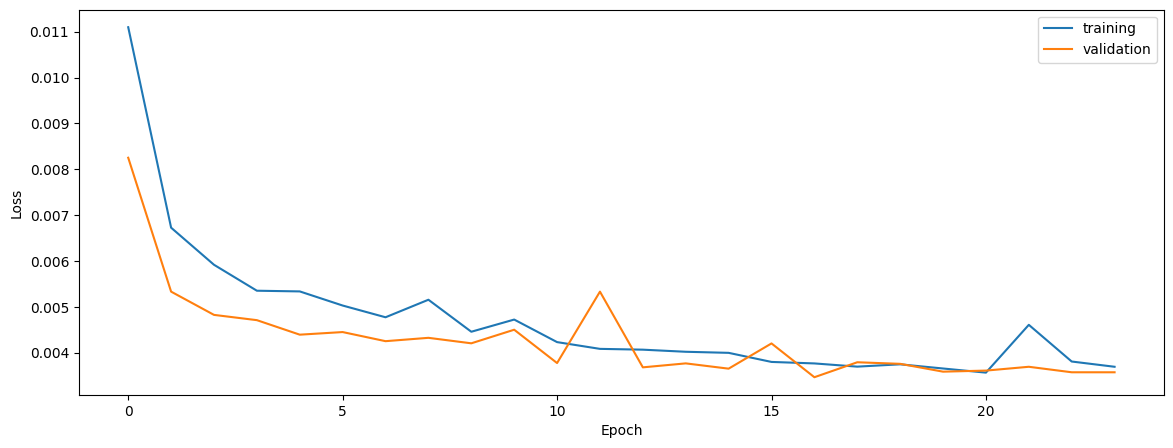

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.7976965228461679
0.7957986830812176
0.7951984886107379


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.7976965228461679
0.7957986830812176
0.7951984886107379


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.8007340419546011
0.7939941361360805
0.7999959057351853


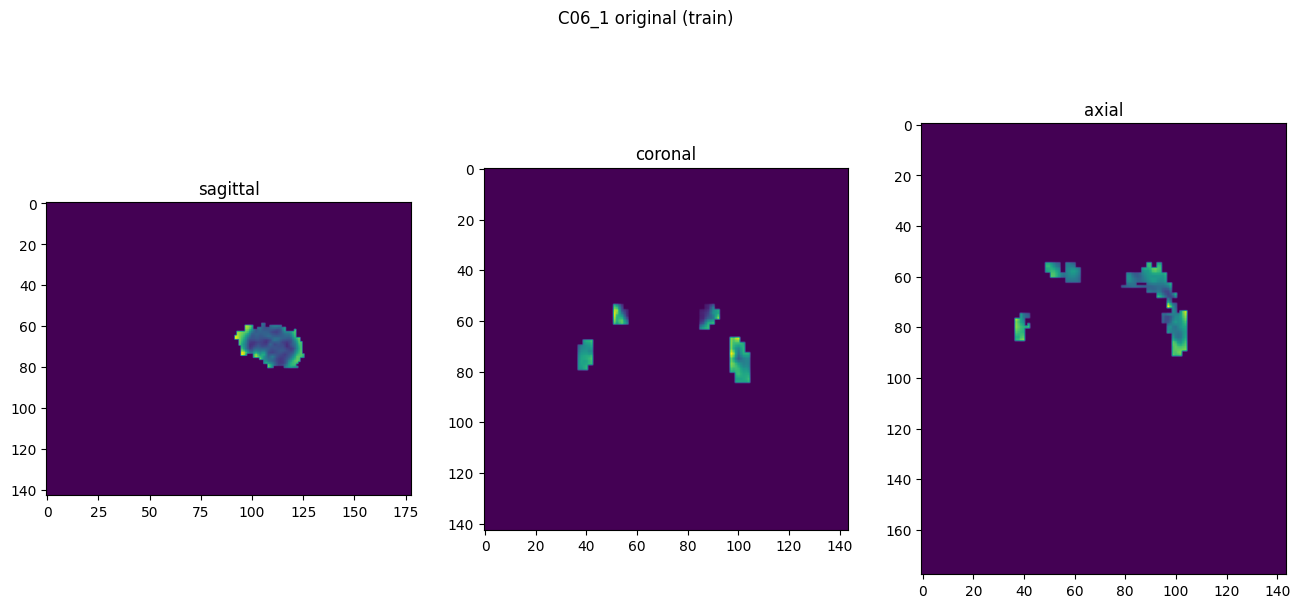

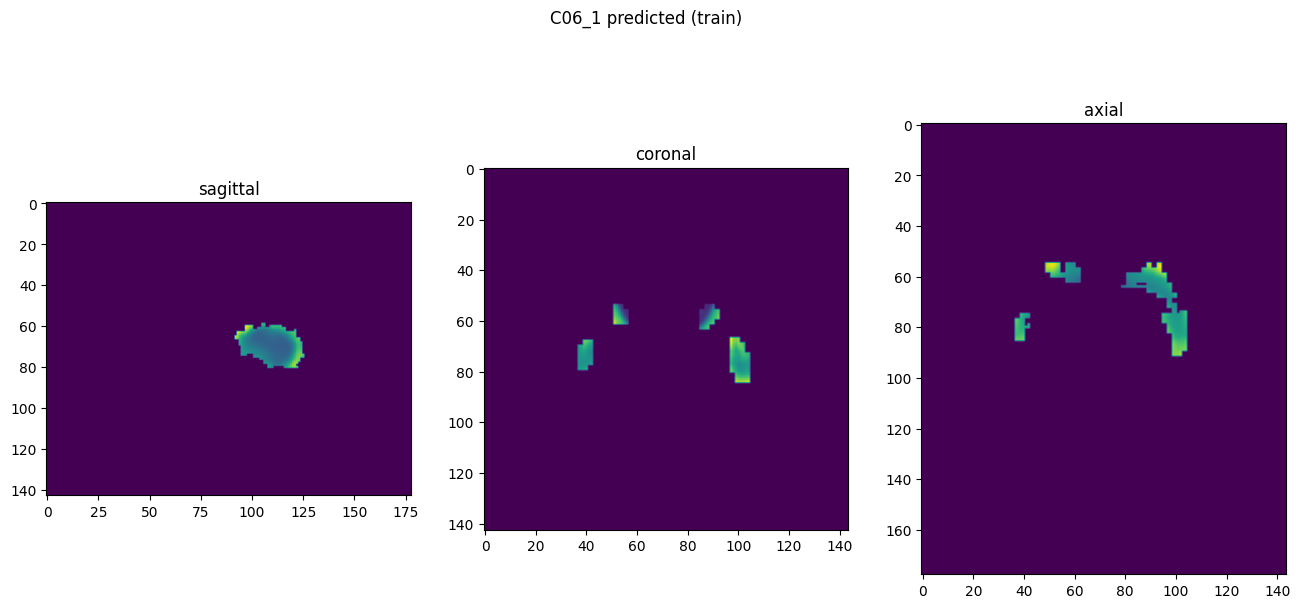

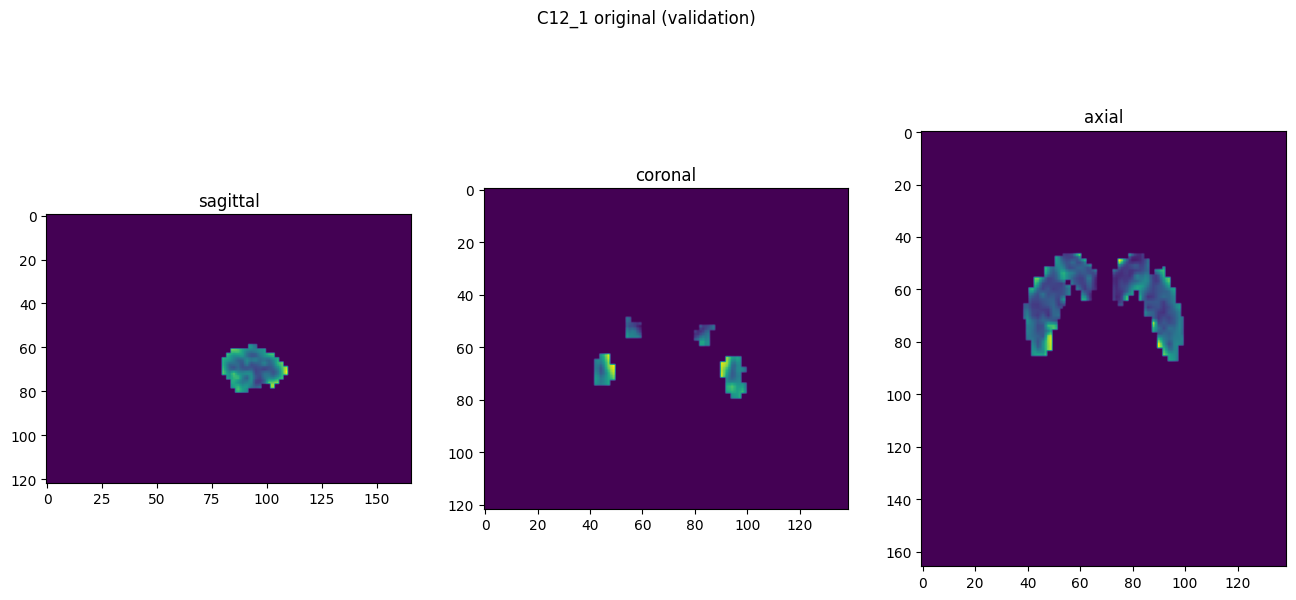

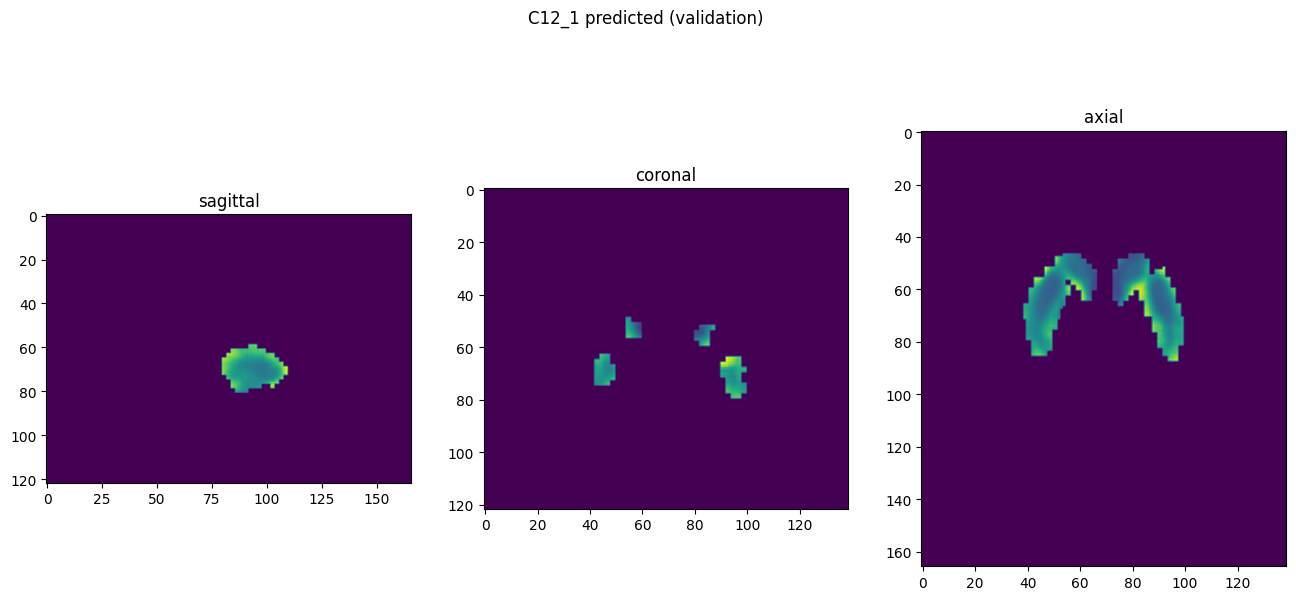

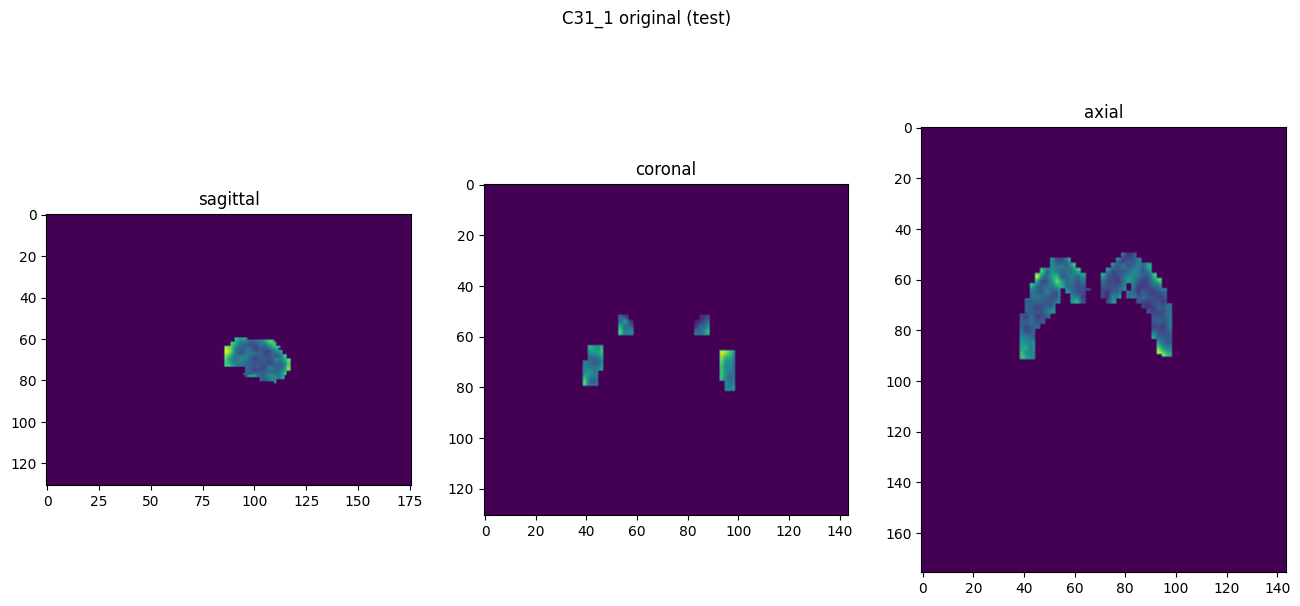

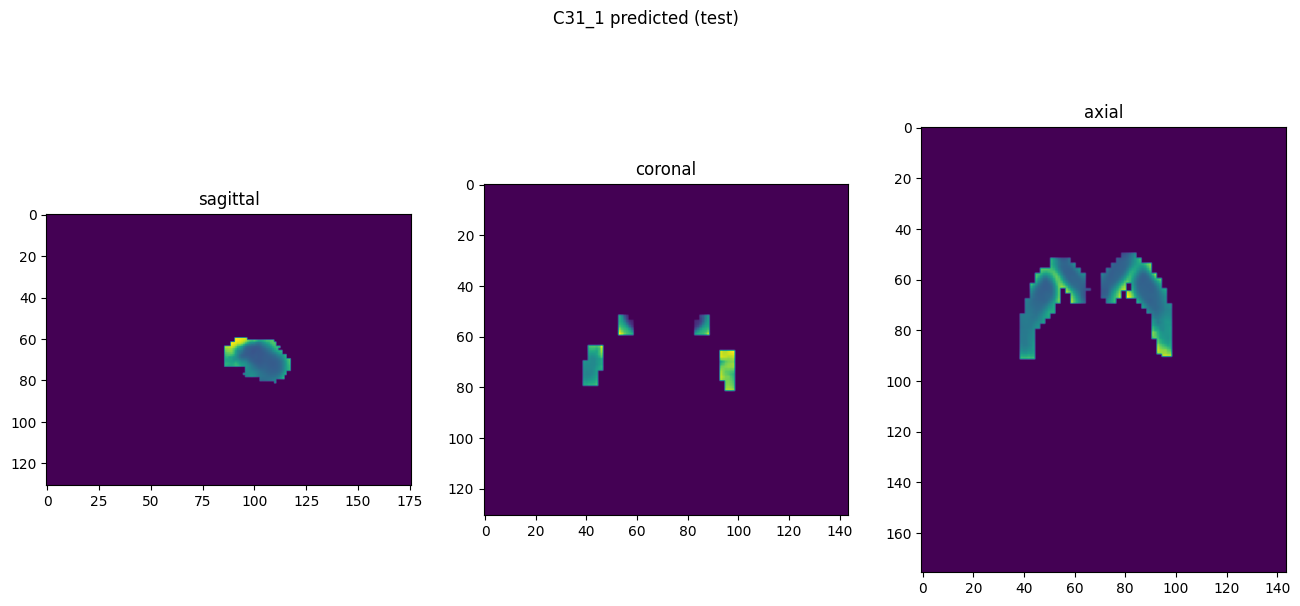

In [10]:
showResults(model, gen, threshold=None, background=False)